# Stereopsis

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

This notebook gives an introduction to basics of 3D reconstruction from a stereo image pair.

## Simple stereo pair

In a simple stereo pair two images (left and right) have been captured using a setup where the cameras are similar, their x axes are collinear, and their y and z axes are parallel. Hence the correspondences always share the same y coordinate, and the disparity is only along the x axis. The disparities are inversely proportional to the depth, and hence, they provide 3D information about the scene. However, recovering the disparity map is often challenging because of lacking details.

Here is an example of a simple stereo pair.

In [3]:
Left = cv2.imread('images/aloeL.jpg')
Right = cv2.imread('images/aloeR.jpg')

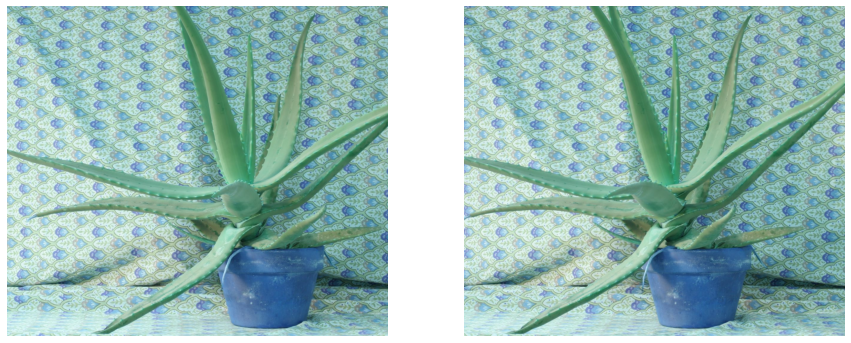

In [4]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(Left)
plt.axis('off')
fig.add_subplot(122)
plt.imshow(Right)
plt.axis('off');

In [5]:
gLeft = cv2.cvtColor(Left,cv2.COLOR_RGB2GRAY)
gRight = cv2.cvtColor(Right,cv2.COLOR_RGB2GRAY)

Here is also the corresponding ground truth disparity map.

In [6]:
GT = cv2.imread('images/aloeGT.png')

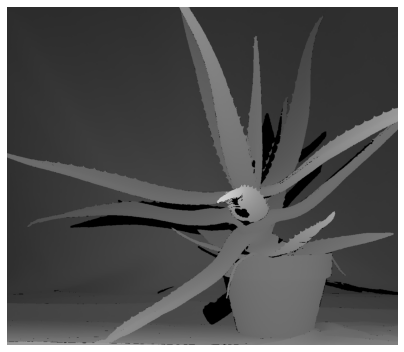

In [7]:
plt.figure(figsize=(7,7))
plt.imshow(GT, cmap='gray')
plt.axis('off');

Next, we use a block-matching based stereo algorithm to reconstruct the disparity map. We assume that the maximum disparity is 256. The resulting depth map is shown below. As we can see there are many error and holes in the depth map obtained. This is a common problem in stereo matching.

In [8]:
stereoMatcher = cv2.StereoBM_create(256)

In [9]:
depth = stereoMatcher.compute(gLeft, gRight)

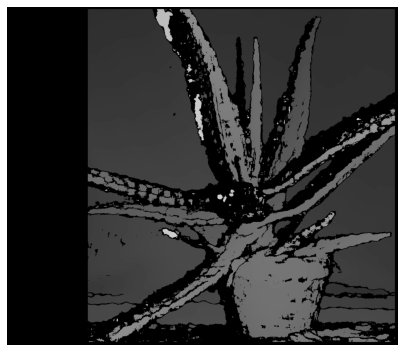

In [10]:
plt.figure(figsize=(7,7))
plt.imshow(depth, cmap='gray')
plt.axis('off');

We also try another method, semi-global block matching algorithm, that is based on the [article](http://www.ifp.uni-stuttgart.de/publications/phowo11/180Hirschmueller.pdf). We can notice that the result is slightly better.

In [11]:
stereoMatcher2 = cv2.StereoSGBM_create(0,256,7)

In [12]:
depth2 = stereoMatcher2.compute(gLeft, gRight)

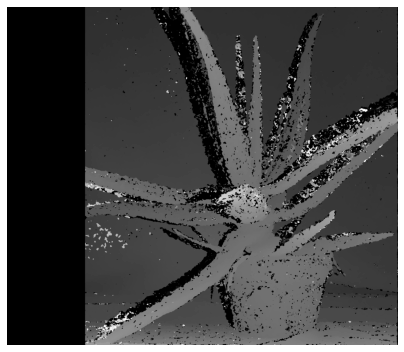

In [13]:
plt.figure(figsize=(7,7))
plt.imshow(depth2, cmap='gray')
plt.axis('off');

## Epipolar geometry

In a general stereo pair the cameras can be in arbitrary positions and orientations. They can even have different internal parameters. In that case we can solve the epipolar geometry between the cameras, and calculate the epipolar lines that help in establishing the correspondences. For every point in the left image there is an epipolar line in the right image where the correspondences are located, and vice versa.

First we read the image pair and use SIFT features to find some matches.


In [14]:
img1=cv2.cvtColor(cv2.imread('images/rdimage.001.jpg'),cv2.COLOR_RGB2GRAY)
img2=cv2.cvtColor(cv2.imread('images/rdimage.002.jpg'),cv2.COLOR_RGB2GRAY)

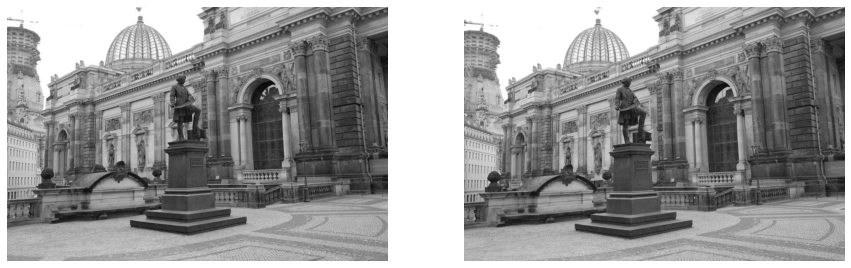

In [15]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(img1, cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(img2, cmap='gray')
plt.axis('off');

In [16]:
sift = cv2.SIFT_create()

In [17]:
kp1, desc1 = sift.detectAndCompute(img1,None)
kp2, desc2 = sift.detectAndCompute(img2,None)

In [18]:
bf = cv2.BFMatcher()

In [19]:
matches = bf.knnMatch(desc1,desc2, k=2)

In [20]:
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])

In [21]:
good = sorted(good, key = lambda x:x[0].distance)

In [22]:
img_match = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good[:50],None,flags=2)

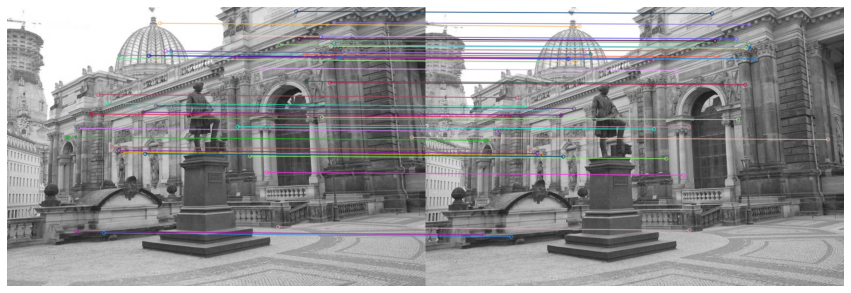

In [23]:
plt.figure(figsize=(15,8))
plt.imshow(img_match)
plt.axis('off');

There might still be outliers among the matches, so we use RANSAC to estimate the fundamental matrix $\mathbf{F}$ that gives a simple relationship $\mathbf{x'}^T\mathbf{F}\mathbf{x} = 0$ betweeen the valid matches.

In [24]:
pts1 = np.zeros((len(good), 2))
pts2 = np.zeros((len(good), 2))
for i in range(len(good)):
    i1 = good[i][0].queryIdx
    i2 = good[i][0].trainIdx
    pts1[i,:] = kp1[i1].pt
    pts2[i,:] = kp2[i2].pt

In [25]:
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_RANSAC)

Here is the fundamental matrix:

In [26]:
print(F)

[[ 1.48763983e-07 -1.25097021e-05 -2.60228016e-03]
 [ 1.46807888e-05  4.25425550e-07 -1.29852532e-01]
 [ 1.38734789e-03  1.29136054e-01  1.00000000e+00]]


We also get the inliers that satisfy the epipolar constraint:

In [27]:
inliers = [good[i] for i in range(len(mask)) if mask[i,0]]

In [28]:
img_match2 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,inliers[:50],None,flags=2)

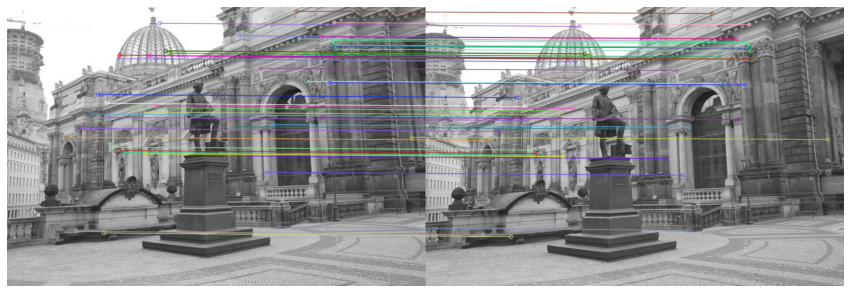

In [29]:
plt.figure(figsize=(15,8))
plt.imshow(img_match2)
plt.axis('off');

These are the inlier points:

In [30]:
pt1 = pts1[mask.ravel()==1,:]
pt2 = pts2[mask.ravel()==1,:]

Next, we calculate the epipolar lines in the second image for the points in the first image and visualize few of them below.

In [31]:
lines1 = cv2.computeCorrespondEpilines(pt1, 1, F)

In [32]:
# This function determines the start and the end points of the line.
def line_bb(line, height, width):
    a=line[0]; b=line[1]; c=line[2]
    if b != 0:
        if c*b < 0 and c/b > -height:
            y0 = -c/b; x0 = 0
        if (a*width+c)*b < 0 and (a*width+c)/b > -height:
            y1 = -(a*width+c)/b ; x1 = width
    if a != 0:
        if c*a < 0 and c/a > -width:
            x0 = -c/a; y0 = 0
        if (b*height+c)*a < 0 and (b*height+c)/a > -width:
            x1 = -(b*height+c)/a ; y1 = height
    return x0,y0,x1,y1

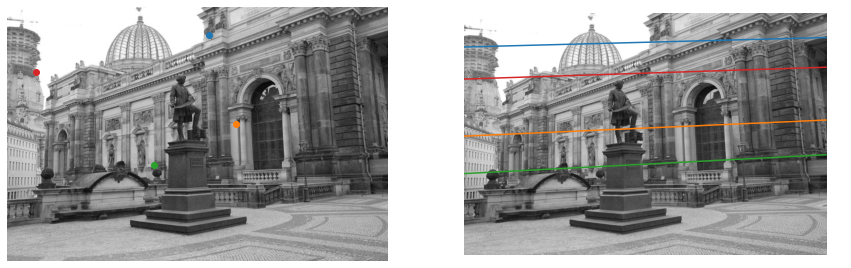

In [33]:
ind=[100,300,700,900]
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(img1,cmap='gray')
for i in ind:
    plt.plot(pt1[i,0],pt1[i,1],'o')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(img2,cmap='gray')
for i in ind:
    x0,y0,x1,y1 = line_bb(lines1[i,0,:],*img1.shape)
    plt.plot([x0,x1],[y0,y1])
plt.axis('off');

Then we can rectify the images to make them a simple stereo pair where the correspondences have the same y coordinate. The rectified images are show below.

In [34]:
ret, H1, H2 = cv2.stereoRectifyUncalibrated(pt1,pt2,F,img1.shape[::-1])

In [35]:
recL = cv2.warpPerspective(img1, H1, img1.shape[::-1])

In [36]:
recR = cv2.warpPerspective(img2, H2, img2.shape[::-1])

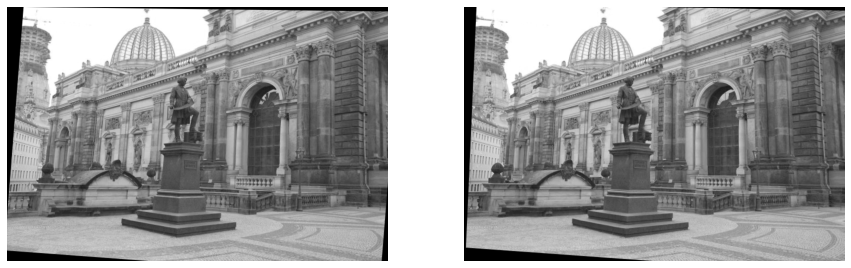

In [37]:
fig=plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(recL, cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(recR, cmap='gray')
plt.axis('off');

Using the rectified images we can perform stereo matching with the same methods as above. The disparity map obtained is presented below.

In [38]:
stereoM = cv2.StereoSGBM_create(-16,64,7)

In [39]:
dep = stereoM.compute(recL, recR)

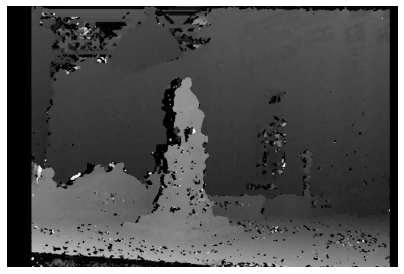

In [40]:
plt.figure(figsize=(7,7))
plt.imshow(dep,cmap='gray')
plt.axis('off');